230323_A_0.5mmh
230330_A_0.4mmh
230406_A_0.2mmh
230517_A_0.3mmh
230323_A_0.5mmh
sPV: 0.634 mm/h
d: 2.4 mm
FWHM: 28.71 arcsec
mu-tau: 0.0129 cm2 V-1
I0_fit: 5.365274070270295e-05 A


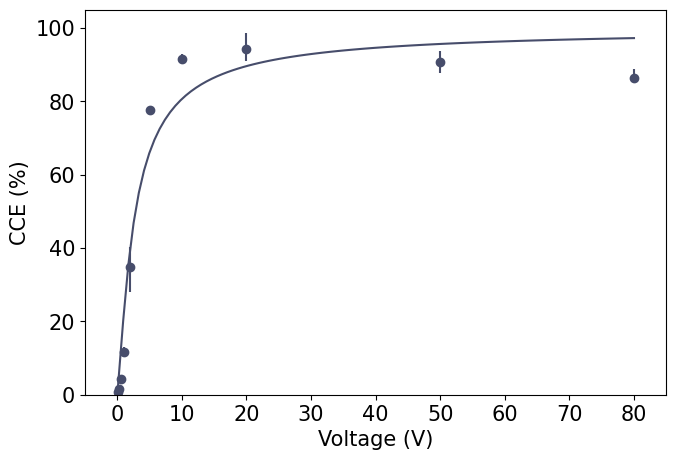

230330_A_0.4mmh
sPV: 0.481 mm/h
d: 2.2 mm
FWHM: 37.34 arcsec
mu-tau: 0.0114 cm2 V-1
I0_fit: 9.496100080076995e-05 A


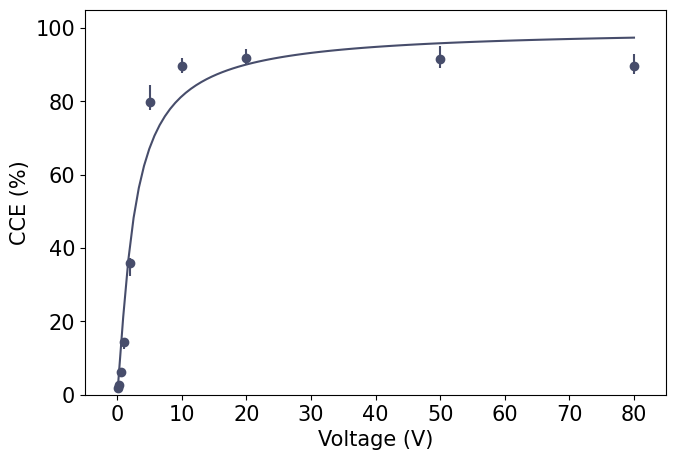

230406_A_0.2mmh
sPV: 0.238 mm/h
d: 3.9000000000000004 mm
FWHM: 18.4 arcsec
mu-tau: 0.0177 cm2 V-1
I0_fit: 0.0005810484736902826 A


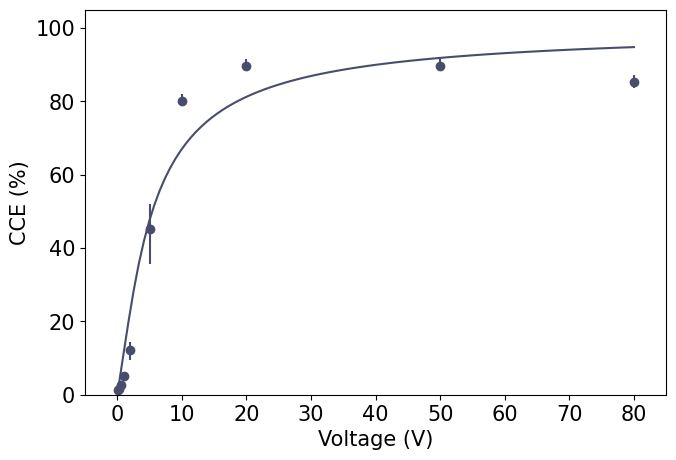

230517_A_0.3mmh
sPV: 0.224 mm/h
d: 2.9 mm
FWHM: 15.33 arcsec
mu-tau: 0.0078 cm2 V-1
I0_fit: 0.0002857334554257861 A


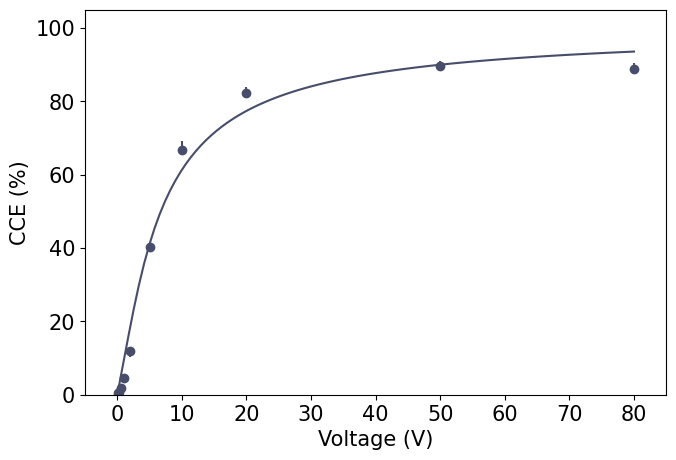

In [1]:
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

# Choose the directory
csv_dir = '../Data/FigureS25_mu-tau'

save_option = True
figsavepath = "../Figures/FigureS25_mu-tau"

# Store the selected file paths in a list
csv_list = glob.glob(f'{csv_dir}/*.csv')
csv_list.sort()

# Make dataframes with its label df_1, df_2, ...
files = []
df_list = []
voltages = []
sample_ids = []
Responses = []
for i, csv in enumerate(csv_list):
    file_name = os.path.basename(csv)[:-4]
    file_info = file_name.split('-')
    sample_id = file_info[0] + '_A_' + file_info[1] #230323_A_0.5mmh
    voltage = float(file_name.split('_')[-1][:-1])
    files.append(file_name)
    sample_ids.append(sample_id)
    voltages.append(voltage)
    df = pd.read_csv(csv)
    df_list.append(df)

    X = df['Time (s)'].to_list()
    Y = df['Current (A)'].to_list()
    
    # Define on time as 70 < t < 85
    df_on = df[70 < df['Time (s)']]
    df_on = df_on[df_on['Time (s)'] < 85]
    X_on = df_on['Time (s)'].to_list()
    Y_on = df_on['Current (A)'].to_list()
    
    # Define off time as t > 110
    df_off = df[df['Time (s)'] > 110]
    X_off = df_off['Time (s)'].to_list()
    Y_off = df_off['Current (A)'].to_list()
    
    # Calculation
    I_on = np.mean(Y_on) - np.mean(Y_off)
    I_on_min = min(Y_on) - np.mean(Y_off)
    I_on_max = max(Y_on) - np.mean(Y_off)
    Responses.append([I_on,I_on_min,I_on_max])
    
    # Check
    # print('{:02d}: {}'.format(i+1, file_name))
    # print(f'Photocurrent: {I_on*1e6:.2f} µA')
    # plt.plot(X,Y,c='blue')
    # plt.plot(X_on,Y_on,c='red')
    # plt.plot(X_off,Y_off,c='green')
    # plt.show()

check = sample_ids[-1]
for sample_id in sample_ids:
    if sample_id != check:
        print(sample_id)
        check = sample_id
        
color = '#474D6B'

# thickness (cm)
thickness_dict = {'230323_A_0.5mmh': 0.24,
                  '230330_A_0.4mmh': 0.22,
                  '230406_A_0.2mmh': 0.39,
                  '230517_A_0.3mmh': 0.29
                 }

# electrode area (cm2)
area_dict = {'230323_A_0.5mmh': 0.25,
             '230330_A_0.4mmh': 0.146,
             '230406_A_0.2mmh': 0.827,
             '230517_A_0.3mmh': 0.315
            }

# sPV (mm/h)
sPV_dict = {'230323_A_0.5mmh': 0.634,
             '230330_A_0.4mmh': 0.481,
             '230406_A_0.2mmh': 0.238,
             '230517_A_0.3mmh': 0.224
            }

# FWHM (arcsec)
FWHM_dict = {'230323_A_0.5mmh': 28.71,
             '230330_A_0.4mmh': 37.34,
             '230406_A_0.2mmh': 18.40,
             '230517_A_0.3mmh': 15.33
            }

# summarize the data for each sample
X = []
Y = []
Y_min = []
Y_max = []

for i, sample in enumerate(sample_ids):
    x = voltages[i] # voltage
    response = Responses[i]
    
    X.append(x)
    Y.append(response[0])
    Y_min.append(response[1])
    Y_max.append(response[2])
    
    if x == 80: # last file for each sample
        print(sample)
        ## Hecht Fitting ##
        L = thickness_dict[sample] # grab thickness
        
        def Hecht_equation(V, I0, mu_tau):
            # voltage, Saturated Output, Length, mu-tau
            E = V/L # electric field (V/cm)
            I = I0 * mu_tau * E / L * (1 - np.exp(- L / mu_tau / E))
            return I
        
        # guess
        I0_guess = max(Y)
        mu_tau_guess = 0.01
        
        #fitting
        popt, pcov = curve_fit(Hecht_equation, X, Y, p0=[I0_guess, mu_tau_guess])        
        X_fit = np.linspace(min(X),max(X),100)
        Y_fit = Hecht_equation(X_fit, *popt)

        # Fitted Parameters
        I0_fit, mu_tau_fit = popt
        
        # Define Y as CCE
        Y = [y/I0_fit*100 for y in Y] # Charge collection efficiency
        Y_min = [y/I0_fit*100 for y in Y_min] # Charge collection efficiency
        Y_min = [m-n for m,n in zip(Y,Y_min)] # low error
        Y_max = [y/I0_fit*100 for y in Y_max] # Charge collection efficiency
        Y_max = [m-n for m,n in zip(Y_max,Y)] # high error
        Y_fit = [y/I0_fit*100 for y in Y_fit]
        
        # sPV, FWHM
        print(f'sPV: {sPV_dict[sample]} mm/h')
        print(f'd: {thickness_dict[sample]*10} mm')
        print(f'FWHM: {FWHM_dict[sample]} arcsec')
        print(f'mu-tau: {mu_tau_fit:.4f} cm2 V-1')
        print(f'I0_fit: {I0_fit} A')
        
        # plot
        plt.rcParams["font.size"] = 15
        fig = plt.figure(figsize=(7.5,5))
        plt.errorbar(x=X,y=Y,yerr=[Y_min,Y_max],linestyle='',marker='o',c=f'{color}')
        plt.plot(X_fit,Y_fit,c=color)
        plt.xlabel('Voltage (V)')
        plt.ylabel('CCE (%)')
        plt.xlim(-5,85)
        plt.ylim(0,105)
        
#         plt.text(25, 60, f'sPV: {sPV_dict[sample]:.2f} mm/h', ha='left', va='bottom',color="black",fontsize=13)
#         plt.text(25, 50, f'd: {L} cm', ha='left', va='bottom',color="black",fontsize=13) 
#         plt.text(25, 40, f'FWHM: {FWHM_dict[sample]:.2f} arcsec', ha='left', va='bottom',color="black",fontsize=13)
#         plt.text(25, 30, f'µτ: {mu_tau_fit:.4f} cm2/V', ha='left', va='bottom',color="black",fontsize=13)
        
        figsavepath_ = f'{figsavepath}_{sample}.svg'
        if save_option:
            plt.savefig(figsavepath_, dpi=1200, bbox_inches='tight')
        # initialize
        X, Y, Y_min, Y_max = [], [], [], []
        plt.show()